# multiDGD training example - from AnnData 

In this tutorial we demonstrate how to train a multiDGD model on data stored in AnnData format.

### Imports

In [ ]:
import os
import requests, zipfile
import numpy as np
import anndata as ad
import scanpy as sc

import multiDGD
from multiDGD.utils import *

# make sure we are in the correct directory
def switch_to_project_dir(name):
    cwd = os.getcwd()
    dir_hierarchy = cwd.split('/')
    index = dir_hierarchy.index(name)
    if index != len(dir_hierarchy) - 1:
        os.chdir('/'.join(dir_hierarchy[:index+1]))
        print('Moved to project directory: ', os.getcwd())

switch_to_project_dir('multiDGD')

In [10]:
## Check if GPUs are available
import torch
torch.cuda.is_available()

False

### Data loading and preparation

Download bone marrow dataset used for examples ([NeurIPS OpenProblems competition 2021 dataset](https://openreview.net/forum?id=gN35BGa1Rt)). 

In [12]:
# Download
data_dir = 'data/'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
os.chdir(data_dir)
file_name = 'human_bonemarrow.h5ad.zip'
file_url = 'https://api.figshare.com/v2/articles/23796198/files/41740251'

file_response = requests.get(file_url).json()
file_download_url = file_response['download_url']
response = requests.get(file_download_url, stream=True)
with open(file_name, 'wb') as f:
    for chunk in response.iter_content(chunk_size=8192):
        f.write(chunk)

# Unzip
with zipfile.ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall('.')
os.remove(file_name)
os.chdir('..')

Load dataset and prepare using the `setup_data` function: here we prepare and save the processed version of the raw data for easy re-use. 

This preprocessing step does the following:

- Split the dataset into train and test set (default fraction: 80% train)
- Specify the location of raw counts (default: `data.X`, you can specify with the `layer` parameter)
- Specify (if any) the cell annotation covariate to initialize the GMM component of the model (with `observable_key`)
- Specify (if any) the nuisance covariates that should be excluded from the biological representation (i.e. batch, donor, disease state) and modelled in the covariate latent space (with `covariate_key`)


In [13]:
data = ad.read_h5ad('./data/human_bonemarrow.h5ad')

In [14]:
data = data[::10,:] # this is just to make it smaller for the demo
# set it up with the model (similar to MultiVI)
data = multiDGD.functions._data.setup_data(
    data, 
    modality_key='feature_types', # adata.var column indicating which feature belongs to which modality
    observable_key='cell_type', # cell annotation key to initialize GMM components 
    covariate_keys=['Site'] # confounders
)
# save this data to keep the train-val-test split for later
data.write_h5ad('./data/example_data.h5ad')

/opt/anaconda3/envs/omics/lib/python3.10/site-packages/multiDGD/functions/_data.py:57: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  data.var['modality'] = modalities


In [15]:
data = sc.read_h5ad('./data/example_data.h5ad')

### Initializing the model

In [16]:
if not os.path.exists('./models/'):
    os.mkdir("./models/")
model = multiDGD.DGD(data=data, save_dir="./models/", model_name="dgd_bonemarrow_default")
model.view_data_setup()

selected  22  number of Gaussian mixture components based on the provided observable.
Covariate model initialized as:

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 4
        
The prepared data consists of the following training set:

        omicsDataset:
            Number of samples: 5708
            Modalities: ['GEX', 'ATAC']
            Features per modality: [13431, 116490]
            Total number of features: 129921
            Scaling of values: sum
        
There is also a validation set with 529 samples
And a test set with 688 samples


We can visualize the initialized cell representations in PCA space.

/opt/anaconda3/envs/omics/lib/python3.10/site-packages/sklearn/decomposition/_pca.py:630: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


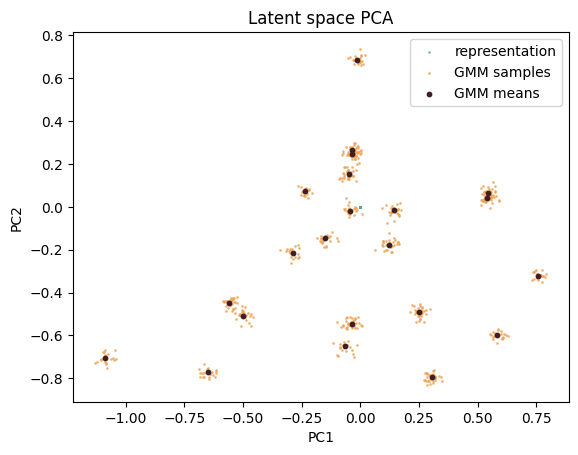

In [17]:
model.plot_latent_space()

### Training the model

Preparing data loaders
Now training
training for  300  epochs with early stopping ( loss )


Training: 100%|██████████| 300/300 [25:19<00:00,  5.07s/epochs, loss=0.137, reconstruction_loss=0.128]


#######################
Training status
#######################
True


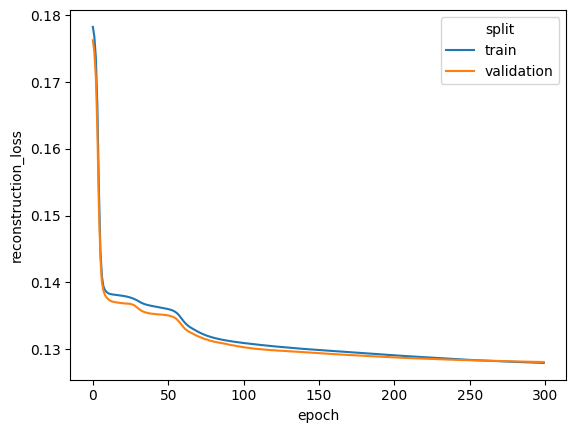

In [16]:
model.train(n_epochs=300)
model.plot_history()

In [17]:
model.save()

### Visualize the cell phenotype latent space

/opt/conda/envs/multiDGD-env/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/conda/envs/multiDGD-env/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/conda/envs/multiDGD-env/lib/python3.9/site-packages/umap/distances.py:1086: Num

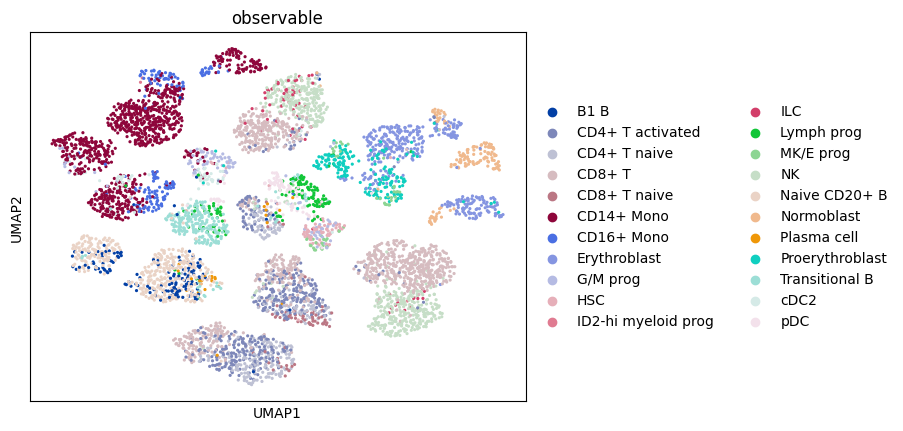

In [18]:
# visualize embeddings (scanpy conform)
# of the training data first
data_train = data.copy()[data.obs['train_val_test'] == 'train']
data_train.obsm['X_multiDGD_latent'] = model.get_representation()

sc.pp.neighbors(adata=data_train, use_rep='latent', n_neighbors=10)
sc.tl.umap(data_train, min_dist=1.0)
sc.pl.umap(data_train, color='observable')

Check the GMM latent space has been updated

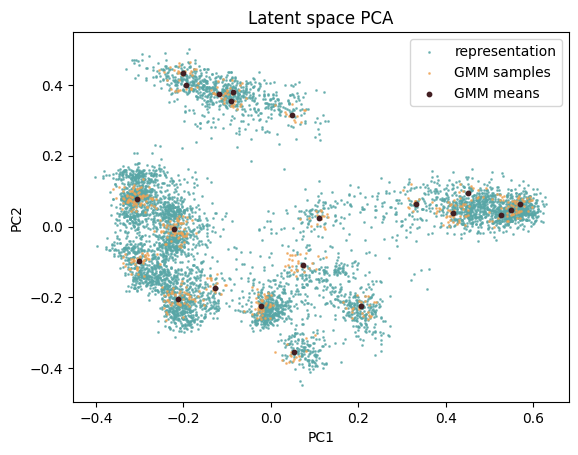

In [19]:
model.plot_latent_space()

### Model loading

In [4]:
# load model from the saved checkpoint
# models are automaticallt saved after training

model = multiDGD.DGD.load(data=data, save_dir='./models/', model_name='dgd_bonemarrow_default')

Covariate model initialized as:

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 4
        
#######################
Training status
#######################
True


### Map the test data to the trained model

In [5]:
# now test the held-out data
model.test() # same as model.predict(), all call predict_new() which is the "developer" method

making potential reps
   all potential reps:  torch.Size([88, 22])
calculating losses for each new sample and potential reps
training selected reps for  20  epochs


Training: 100%|██████████| 20/20 [00:23<00:00,  1.15s/epochs, loss=0.13, reconstruction_loss=0.126]


In [6]:
model.save()

/opt/conda/envs/multiDGD-env/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/conda/envs/multiDGD-env/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/conda/envs/multiDGD-env/lib/python3.9/site-packages/umap/distances.py:1086: Num

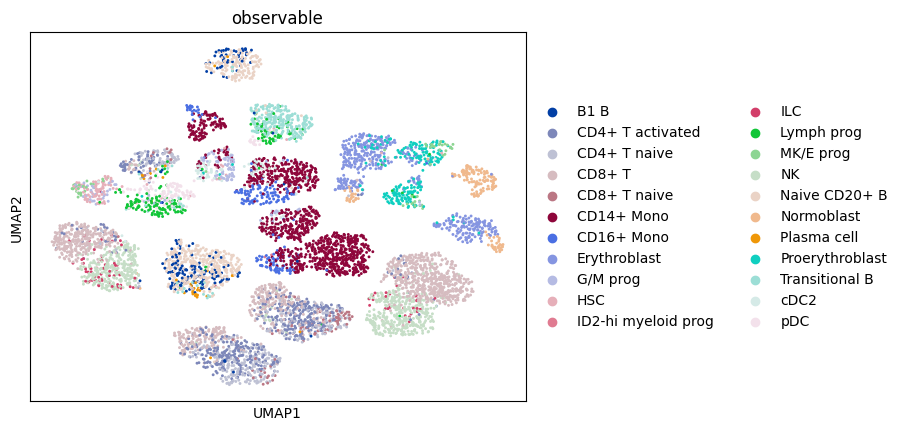

/opt/conda/envs/multiDGD-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


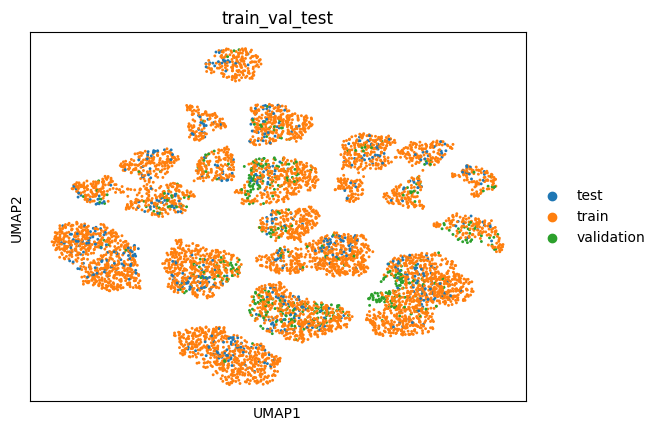

/opt/conda/envs/multiDGD-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


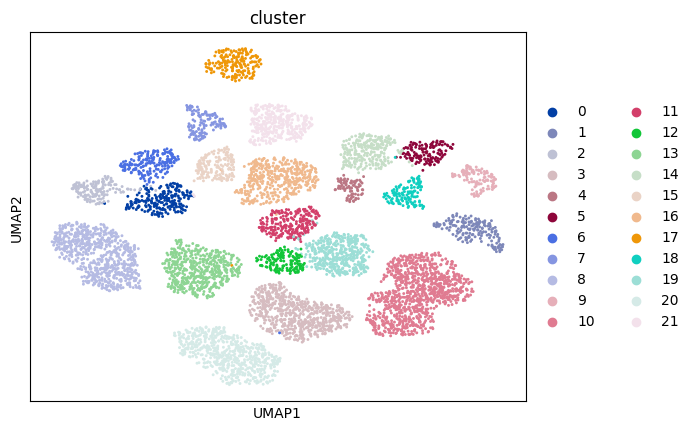

In [7]:
# now visualize the embeddings of all data (train, val, test)
# by cell type, cluster assignment and the data split

data.obsm['latent'] = model.get_representation(split='all')
data.obs['cluster'] = model.clustering(split='all').astype(str)

sc.pp.neighbors(adata=data, use_rep='latent', n_neighbors=10)
sc.tl.umap(data, min_dist=1.0)
sc.pl.umap(data, color='observable')
sc.pl.umap(data, color='train_val_test')
sc.pl.umap(data, color='cluster')

<AxesSubplot: >

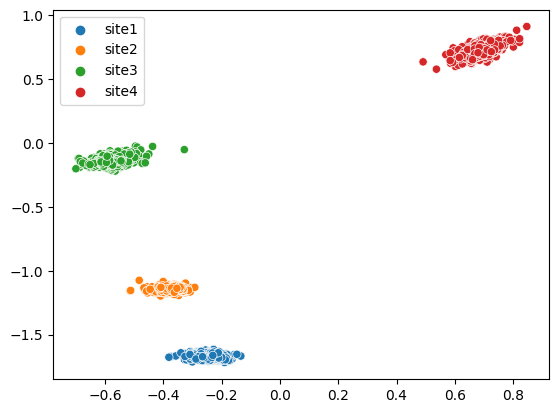

In [10]:
# new addition: "sample-level" representations (or covariate representations)

cov_rep = model.get_covariate_representation(split="train")

# plot
import seaborn as sns
sns.scatterplot(x=cov_rep[:, 0], y=cov_rep[:, 1], hue=data.obs[data.obs["train_val_test"]=="train"]["Site"].values)